### Results For paper

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [3]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [4]:
np.random.seed(seed = 0)

### Load Data

In [5]:
# s3_path = 'nneehal/DATA/odata/m6_knn_no_cluster_only_latent'
# data_path = '../temp'

# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

In [6]:
%%time
p = '../temp/odata_knn/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 114 ms, sys: 24.9 ms, total: 139 ms
Wall time: 155 ms


In [7]:
### Optional(filter registrations after  a particular month and before a particular month)

In [8]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [9]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [10]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [11]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [12]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [13]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 2.63 s, sys: 9.61 ms, total: 2.64 s
Wall time: 2.64 s


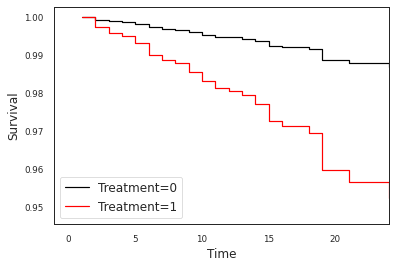

In [14]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [15]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        2.614083  0.105919  3.238971

In [16]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      2.422           1.069        2.265    0.023
Gender                   0.496           0.335        1.483    0.138
Total Cost               0.261           0.234        1.114    0.265
Tobacco use             -0.195           0.633       -0.309    0.757
Obesity                  0.105           0.337        0.312    0.755
Hypertension            -0.158           0.368       -0.429    0.668
Hypothyroid             -0.833           0.732       -1.139    0.255
Disease Count            0.965           1.487        0.649    0.516
Line of Bussiness       -0.604           0.576       -1.050    0.294
Treatment                1.292           0.748        1.727    0.084

### ER

In [17]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [18]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.61 s


In [19]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [20]:
lrsumm

test_statistic         p  -log2(p)
ER       10.850255  0.000988  9.983462

In [21]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.199           0.446       -2.685    0.007
Gender                  -0.127           0.175       -0.723    0.470
Total Cost               0.202           0.104        1.939    0.053
Tobacco use              0.307           0.230        1.336    0.182
Obesity                  0.008           0.156        0.053    0.958
Hypertension             0.442           0.178        2.476    0.013
Hypothyroid             -0.358           0.285       -1.258    0.209
Disease Count            1.096           0.671        1.634    0.102
Line of Bussiness       -0.808           0.217       -3.722    0.000
Treatment               -0.342           0.210       -1.626    0.104

### IP

In [22]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [23]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.6 s


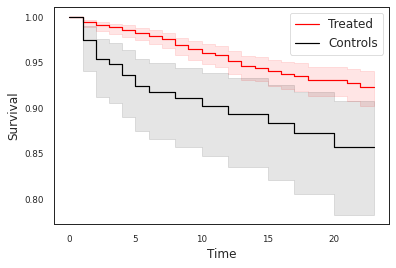

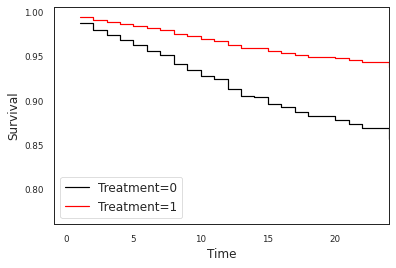

In [24]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [25]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7f89899266a0>>

In [26]:
lrsumm

test_statistic         p  -log2(p)
IP        8.984397  0.002723  8.520616

In [27]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.016           0.622       -1.635    0.102
Gender                  -0.275           0.258       -1.064    0.287
Total Cost               0.617           0.185        3.336    0.001
Tobacco use              0.018           0.326        0.056    0.955
Obesity                  0.306           0.213        1.438    0.150
Hypertension             0.378           0.247        1.531    0.126
Hypothyroid             -0.172           0.344       -0.500    0.617
Disease Count            2.285           0.839        2.723    0.006
Line of Bussiness       -0.267           0.321       -0.831    0.406
Treatment               -0.888           0.273       -3.252    0.001

### Acute Care IP OR ER

In [28]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [29]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.67 s


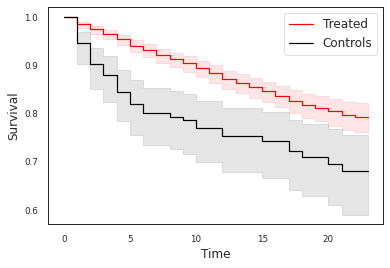

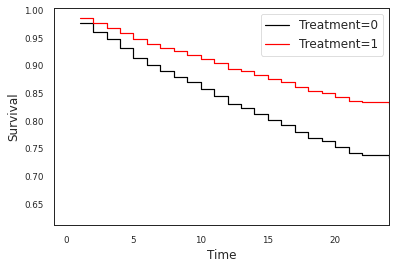

In [30]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [31]:
lrsumm

test_statistic         p   -log2(p)
Acute       14.045379  0.000178  12.452178

In [32]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.036           0.394       -2.631    0.009
Gender                  -0.097           0.155       -0.625    0.532
Total Cost               0.320           0.097        3.310    0.001
Tobacco use              0.209           0.207        1.007    0.314
Obesity                  0.135           0.136        0.997    0.319
Hypertension             0.408           0.156        2.613    0.009
Hypothyroid             -0.253           0.235       -1.080    0.280
Disease Count            1.379           0.575        2.398    0.016
Line of Bussiness       -0.611           0.197       -3.105    0.002
Treatment               -0.509           0.184       -2.774    0.006

### Load all Log Rank Sums in a matrix

In [33]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [34]:
df2

logRank statistic   p-value  RMST difference
Diabetes                   2.614083  0.105919        -0.520041
Emergency Visits          10.850255  0.000988         1.858513
Inpatient Vistis           8.984397  0.002723         1.275697
Acute Care                14.045379  0.000178         2.445020